<a href="https://colab.research.google.com/github/itchyfeet-patient/Beautiful-Exploration/blob/master/Exploration_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **11-14.프로젝트 : CIFAR-10 이미지 생성하기 🏞**

GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

* 이미지 데이터의 shape가 (28, 28, 1)에서 **(32, 32, 3)**으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
* 이미지가 단색의 grayscale에서 RGB **3채널**의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
* **입력데이터 전체 차원이 3~4배 증가**하면서, 학습이 진행되는 양상이 다소 달라집니다.  
우선 주요 라이브러리 버전을 확인하고 진행합시다.

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import glob
import time
import os
import PIL
import tensorflow as tf
import imageio
import numpy as np
import cv2
import tensorflow_addons as tfa

from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


print(tf.__version__)
print(imageio.__version__)


2.8.2
2.9.0


## **STEP 1. 작업환경 구성하기**
다음과 같이 작업환경을 구성합시다.

In [ ]:
# mkdir -p ~/content/drive/MyDrive/dataset/dcgan_newimage/cifar10/generated_samples
# mkdir -p ~/content/drive/MyDrive/dataset/dcgan_newimage/cifar10/training_checkpoints
# mkdir -p ~/content/drive/MyDrive/dataset/dcgan_newimage/cifar10/training_history

## **STEP 2. 데이터셋 구성하기**
CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

* 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
* 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
* tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

학습 시간이 너무 오래 걸린다면 한 종류의 데이터만 추출해 진행해도 좋습니다. 

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

shape이 (32,32,3) 입니다. 50000장의 이미지가 있네요

In [ ]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [ ]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [ ]:
train_x.shape

(50000, 32, 32, 3)

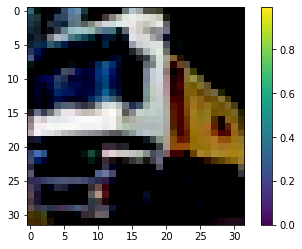

In [ ]:
plt.imshow(train_x[1])
plt.colorbar()
plt.show()

트럭 이미지가 출력됐습니다!

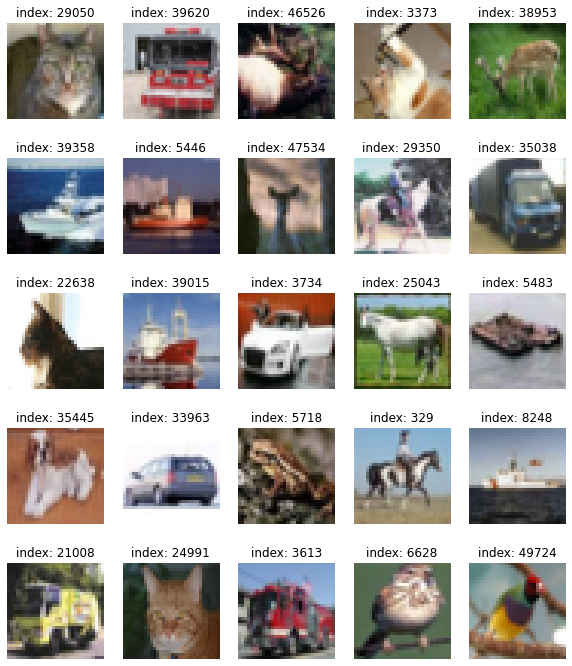

In [ ]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    j = np.random.randint(1, 50000)
    plt.imshow((train_x[j]+ 1)/2) # 범위를 0,1로 바꿔줌.
    plt.title(f'index: {j}')
    plt.axis('off')

plt.show()

cifar 10의 이미지가 잘 출력되었습니다.

In [ ]:
BUFFER_SIZE = 50000 # 총 데이터 사이즈와 같거나 크게해서 잘 섞이게 함
BATCH_SIZE = 512 # 512로 에폭높여서 해보기

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **STEP 3. 생성자 모델 구현하기**
* (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
* noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
* 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [ ]:
def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*128, use_bias=False, input_shape=(100,)))
    # 7*7*256 출력값 크기 (임의로 정한거야)
    # input shape (100,)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer 
    model.add(layers.Reshape((4, 4, 128)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False,activation='leaky_relu'))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))


    #model.add(layers.Reshape((4, 4, 256)))
    #model.add(layers.BatchNormalization(momentum=0.9))
    #model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(32, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False,activation='leaky_relu'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    #model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False,activation='leaky_relu')) # 64
    #model.add(layers.BatchNormalization(momentum=0.9))
    #model.add(layers.LeakyReLU(alpha=0.2))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    

    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 2048)              204800    
                                                                 
 batch_normalization_84 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_12 (Reshape)        (None, 4, 4, 128)         0         
                                                                 
 batch_normalization_85 (Bat  (None, 4, 4, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_85 (LeakyReLU)  (None, 4, 4, 128)       

각 층마다 Batch normalization과 leakyrelu를 추가해줬고 transpose convolution 층도 추가해줬습니다.

In [ ]:
noise = tf.random.normal([1, 100])

가우시안 분포를 가지는 랜덤 노이즈를 생성해서


In [ ]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

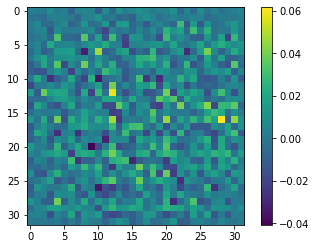

In [ ]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

생성된 노이즈입니다. 이 노이즈를 이용해서 generator가 cifar10 이미지와 비슷한 이미지를 생성하겠죠?

## **STEP 4. 판별자 모델 구현하기**
* (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
* 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum=0.9))    
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))    
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))    
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    # Fourth: Flatten Layer
    model.add(layers.Flatten())

    # Fifth: Dense Layer
    model.add(layers.Dense(1))

    return model

Discrinator도 Batchnormalization과 LeakyRelu 필수입니다!! (GAN 성능 개선을 위한 논문들 참고) 그리고 BN-Activation-Dropout 순서대로 Dropout도 추가해줬습니다. 

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 16, 16, 64)        1792      
                                                                 
 batch_normalization_88 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_88 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_36 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 batch_normalization_89 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                    

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00146445]], dtype=float32)>

## **STEP 5. 손실함수와 최적화 함수 구현하기**
* 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
* 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
* 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# 내부에 시그모이드 함수 적용

이미지 판별은 이진분류이므로 Binary Crossentropy를 사용합니다. 시그모이드 함수를 사용하는 것도 이 이유입니당(0 or 1로 출력되도록)  
discriminator 모델 출력부분에 Sigmoid로 출력하는 분도 계셨습니다.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
generator_optimizer = tf.keras.optimizers.SGD(1e-3) # 1e-3 beta_1 = 0.5, decay=1e-5
discriminator_optimizer = tf.keras.optimizers.SGD(1e-4) # 1e-4 beta_1 = 0.5, decay=1e-5

optimizer를 지정해줍니다. Adam! 근데이제 저는 이것저것 바꿔보다 Adam이 학습을 너무 잘해서? fake accuracy가 너무 커지길래 학습을 좀 천천히 하라고 SGD로 바꿨습니다. 그랬더니 초반엔 fake accuracy가 0.7~0.5에 접근(?) 했습니다.

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## **STEP 6. 훈련과정 상세 기능 구현하기**
* 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.  
* 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.  
* training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [ ]:

@tf.function
def train_step(images):  #(1) 입력데이터
    # real image 역할을 할 image 한 세트를 입력으로 받는다.
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈
    # generator가 fake image를 생성하기 위한 noise를 image 한 세트와 같은 크기인 batch_size만큼 생성
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        # tf.GradientTape()은 가중치 갱신을 위한 gradient를 자동 미분으로 계산하기 위해 with구문열기?
        generated_images = generator(noise, training=True)  #(4) generated_images 생성
        # generator가 noise를 입력받은 후 generated image 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        # discriminator가 real image인 images와 fake image인 generated images를 각각 입력받은 후
        # real_output, fake_output 출력

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        # fake_output, real_output 으로 generator와 discriminator각각의 loss 계산

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
        # fake output, real output으로 discriminator의 정확도 계산

    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # gen tape 와 disc tape를 활용해 gradient 계산.

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    # 계산된 gradient를 optimizer에 입력해 가중치 갱신

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값
    # loss와 accuracy리턴

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2)
        plt.axis('off')
        # plt.imshow((train_x[j]+ 1)/2) # 범위를 0,1로 바꿔줌. np.array
    plt.savefig('/content/drive/MyDrive/dataset/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [ ]:

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')   
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/dataset/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/dataset/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## **STEP 7. 학습 과정 진행하기**
* 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.  
* 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.  
* 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 1000


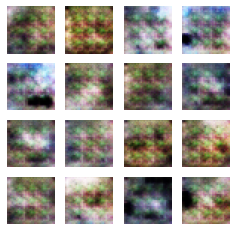

Time for training : 3599 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)


## **STEP 8. (optional) GAN 훈련 과정 개선하기**
* STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
* 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.  

(참고) 아래 언급된 페이지들에서 개선을 위한 아이디어를 얻을 수 있을 것입니다.  
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)  
* [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)  
* [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)  
* [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)

## 개선 Models

*  generator_loss와 discriminator_loss는 0에 가까운게 좋겠지
* real output과 fake output의 accuracy가 1에 가까운 경우 -> 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적  
fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻

### Model_1
노드에서 기본 제공된 예시를 **이용**


def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 8*8*256 출력값 크기 (임의로 정한거야)
    # use_bias 편향 사용할건지?
    # input shape (100,)
    model.add(layers.BatchNormalization())
    # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줌.
    model.add(layers.LeakyReLU())
    # 활성함수가 leakyrelu다 왜임? -> 
    # cnn에서 gradient vanishing problem 을 해결하고 sparse activation으로 촉진시키기 위함


    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    

    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

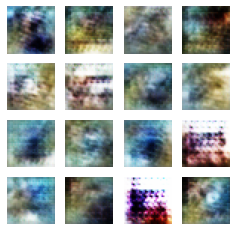

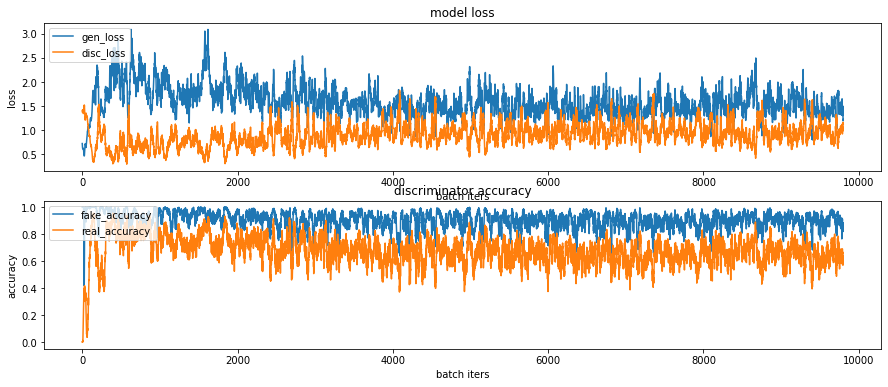

* 이미지 부정확
* fake_accuracy 1수렴

### Model_2
생성자 레이어에 BN, Leaky ReLU 각 레이어마다 추가  
epoch 50 -> 300

def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 7*7*256 출력값 크기 (임의로 정한거야)
    # use_bias 편향 사용할건지?
    # input shape (100,)
    model.add(layers.BatchNormalization())
    # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줌.
    model.add(layers.LeakyReLU())
    # 활성함수가 leakyrelu다 왜임? -> 
    # cnn에서 gradient vanishing problem 을 해결하고 sparse activation으로 촉진시키기 위함


    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    

    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

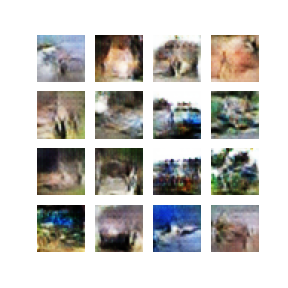

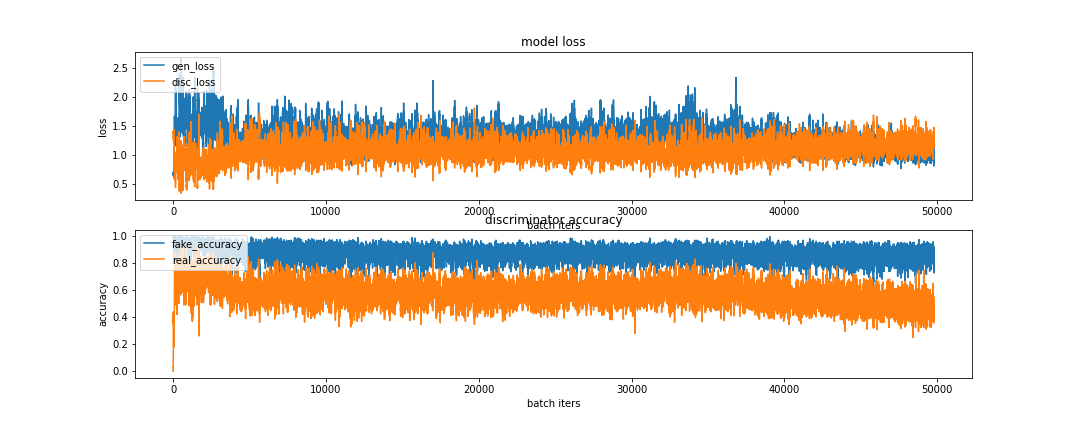

형태가 조금 명확해졌다. BN, Leaky ReLU의 힘

### model_3
생성자 레이어에 BN, Leaky ReLU 각 레이어마다 추가  
판별자 레이어 dropout 0.3->0.5  
epoch 300->100


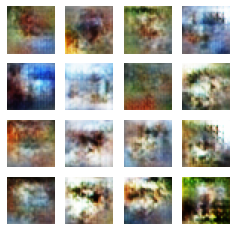

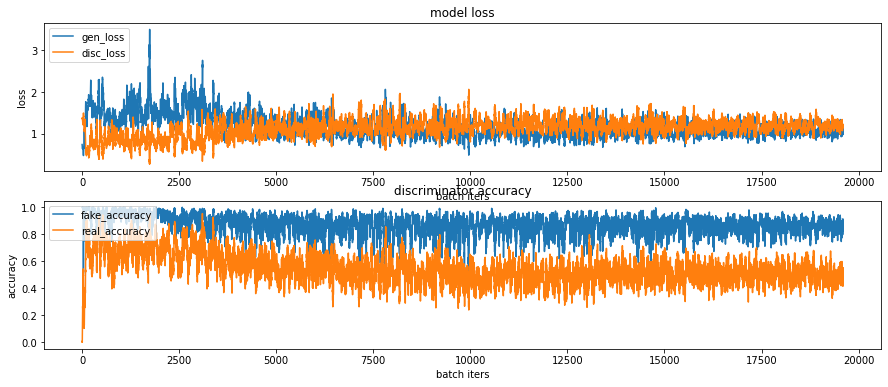

### model_4
생성자 레이어 filter 개수 128->256  
4, 5 번째 레이어 사이에 Convolution layer 한개 추가

def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 7*7*256 출력값 크기 (임의로 정한거야)
    # use_bias 편향 사용할건지?
    # input shape (100,)
    model.add(layers.BatchNormalization())
    # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줌.
    model.add(layers.LeakyReLU())
    # 활성함수가 leakyrelu다 왜임? -> 
    # cnn에서 gradient vanishing problem 을 해결하고 sparse activation으로 촉진시키기 위함


    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    

    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

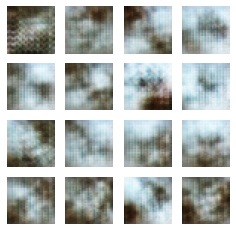

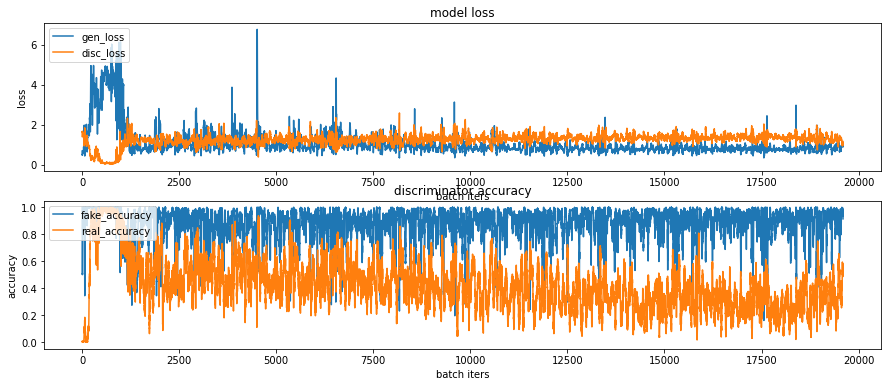

결과물이 너무 별로다

### model_5
생성자 레이어 filter 개수 256->128
5번째 transpose 레이어 다음에 conv 레이어 깔고 마지막엔 출력위해서 conv 또 추가 중간중간 BN, leaky relu 끼워넣어

def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 7*7*256 출력값 크기 (임의로 정한거야)
    # use_bias 편향 사용할건지?
    # input shape (100,)
    model.add(layers.BatchNormalization())
    # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줌.
    model.add(layers.LeakyReLU())
    # 활성함수가 leakyrelu다 왜임? -> 
    # cnn에서 gradient vanishing problem 을 해결하고 sparse activation으로 촉진시키기 위함


    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False
                                     ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))


    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

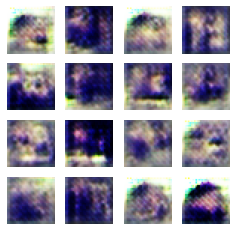

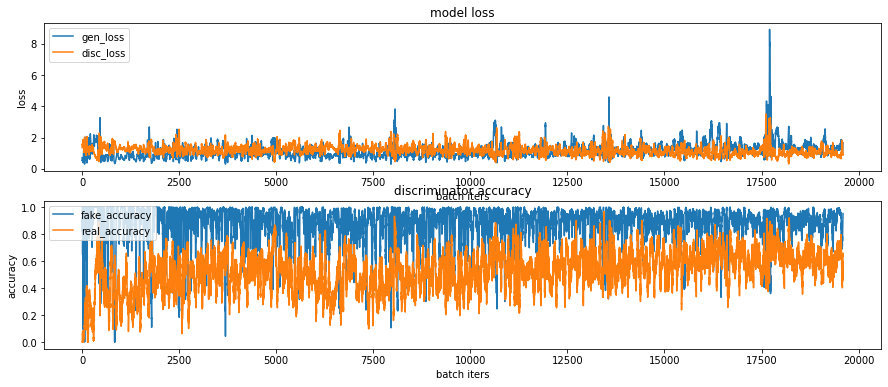

### model_6
고민... cs231n 듣는중이라 vggnet에서 영감을 받아 filter 사이즈를 3*3으로 고침    
leaky relu alpha 기본값이 0.3인데 일반적으로 0.01을 쓴다고 해서 고쳐봄.  
여기서 잠깐 의문이.. 왜 점점 더 이미지가 구져지는가?

def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 7*7*256 출력값 크기 (임의로 정한거야)
    # use_bias 편향 사용할건지?
    # input shape (100,)
    model.add(layers.BatchNormalization())
    # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줌.
    model.add(layers.LeakyReLU(alpha=0.01))
    # 활성함수가 leakyrelu다 왜임? -> 
    # cnn에서 gradient vanishing problem 을 해결하고 sparse activation으로 촉진시키기 위함


    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))


    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False
                                     ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.01))

    model.add(layers.Conv2D(3, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))


    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

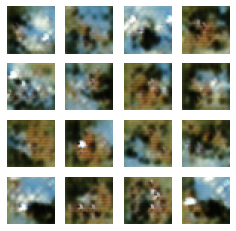

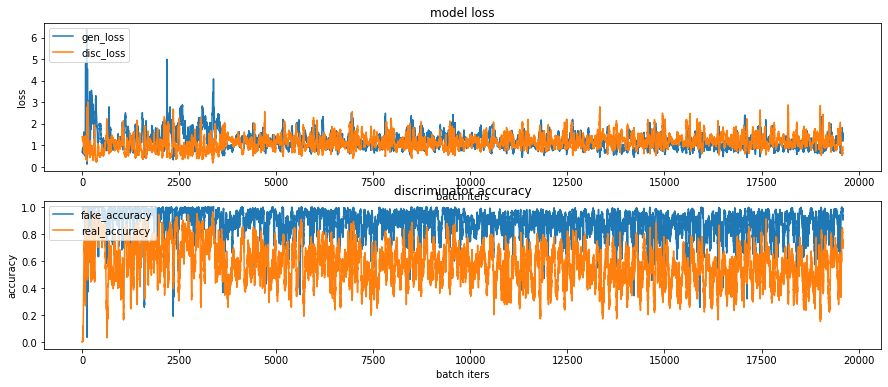

곰팡이같당;

### model_7
batch size = 32  learning rate generate = 0.0003, discriminator = 0.0001 beta_1 = 0.5

def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 8*8*256 출력값 크기 (임의로 정한거야)
    # use_bias 편향 사용할건지?
    # input shape (100,)
    model.add(layers.BatchNormalization(momentum=0.99))
    # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줌.
    model.add(layers.LeakyReLU(alpha=0.2))
    # 활성함수가 leakyrelu다 왜임? -> 
    # cnn에서 gradient vanishing problem 을 해결하고 sparse activation으로 촉진시키기 위함


    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU(alpha=0.2))



    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))


    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

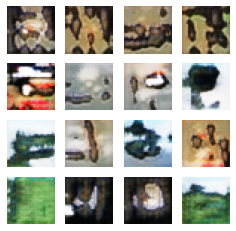

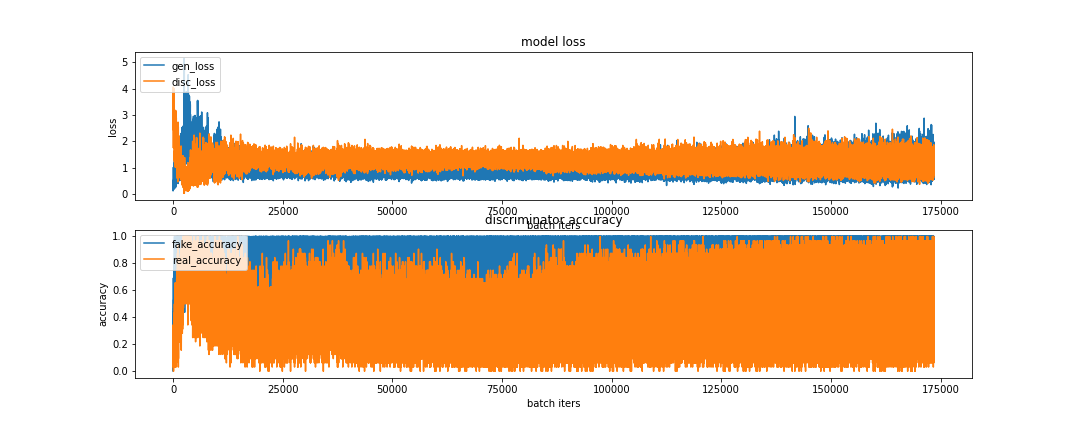

관찰결과, batch size를 줄이면 진폭이 커지는 경향이 있다.

### model_8
activation function relu -> elu

def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    # 8*8*256 출력값 크기 (임의로 정한거야)
    # use_bias 편향 사용할건지?
    # input shape (100,)
    model.add(layers.BatchNormalization(momentum=0.99))
    # 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줌.
    model.add(layers.ELU())
    # 활성함수가 leakyrelu다 왜임? -> 
    # cnn에서 gradient vanishing problem 을 해결하고 sparse activation으로 촉진시키기 위함


    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.ELU())

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.ELU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.ELU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.ELU())



    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    model.add(layers.BatchNormalization(momentum=0.99))
    model.add(layers.ELU())
    
    model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))


    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

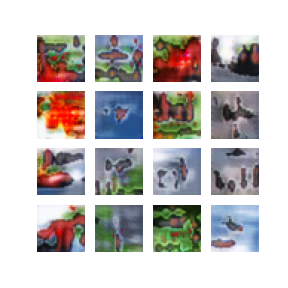

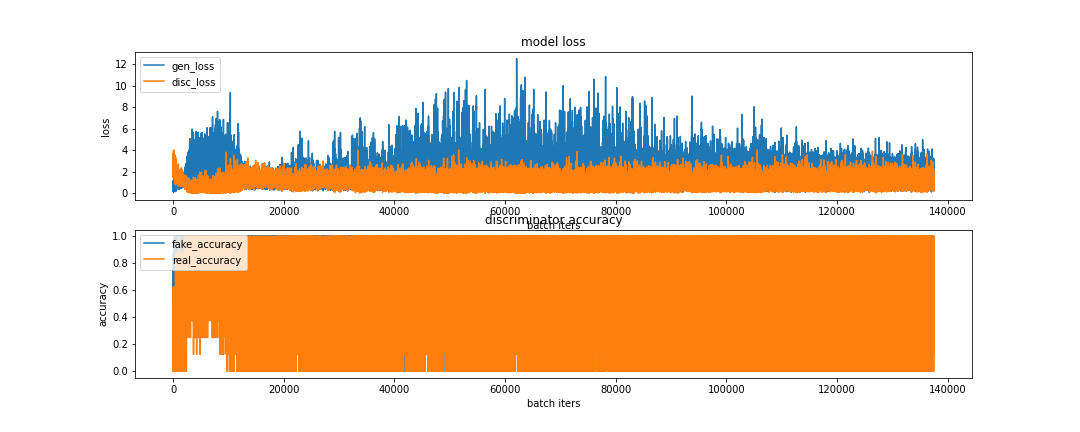

색칠공부 재밌당 ELU는 맞지 않아보인다.

### model_9


def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*128, use_bias=False, input_shape=(100,)))
    # 7*7*256 출력값 크기 (임의로 정한거야)
    # input shape (100,)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))
  
    model.add(layers.Reshape((4, 4, 128)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False,activation='leaky_relu'))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    #model.add(layers.Reshape((4, 4, 256)))
    #model.add(layers.BatchNormalization(momentum=0.9))
    #model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(32, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False,activation='leaky_relu'))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    #model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False,activation='leaky_relu')) # 64
    #model.add(layers.BatchNormalization(momentum=0.9))
    #model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    

    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

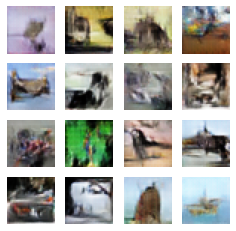

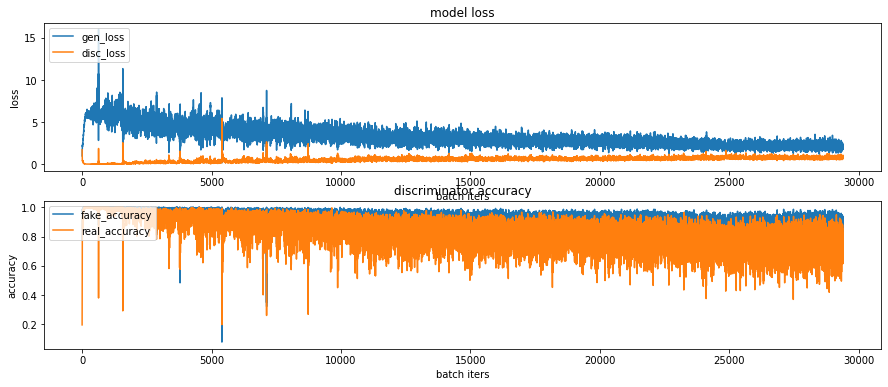

사진 퀄리티가 꽤 좋다. 그런데 왜 accuracy는 떨어지지 않나요?

### model_10
epoch 10정도였는데 벌써 그림이 선명하다. batch size 64

def make_generator_model():
    # 생성자는 시드값으로 부터 이미지를 생성할거야

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    # 임의로 정한 출력값 크기
    # input shape (100,)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.ReLU())
  
    model.add(layers.Reshape((4, 4, 1024)))
    #model.add(layers.BatchNormalization(momentum=0.9))
    #model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding='same', use_bias=False))
    # 업샘플링 층을 사용. 크기를 점차 키워줌. (여태껏 했던 것들의 반대임)
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    
    model.add(layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False))

    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)) # 64
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)) # 64
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.2))    

    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False, \
                                     activation='tanh'))
    

    # 마지막층만 tanh를씀
    # -1 ~ 1 사이의 값으로 픽셀값을 정규화시켰던 데이터셋과 동일하게 하기 위함.

    return model

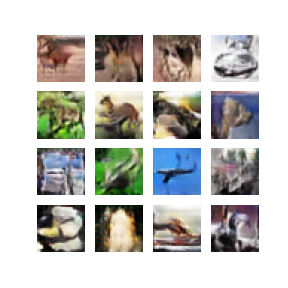

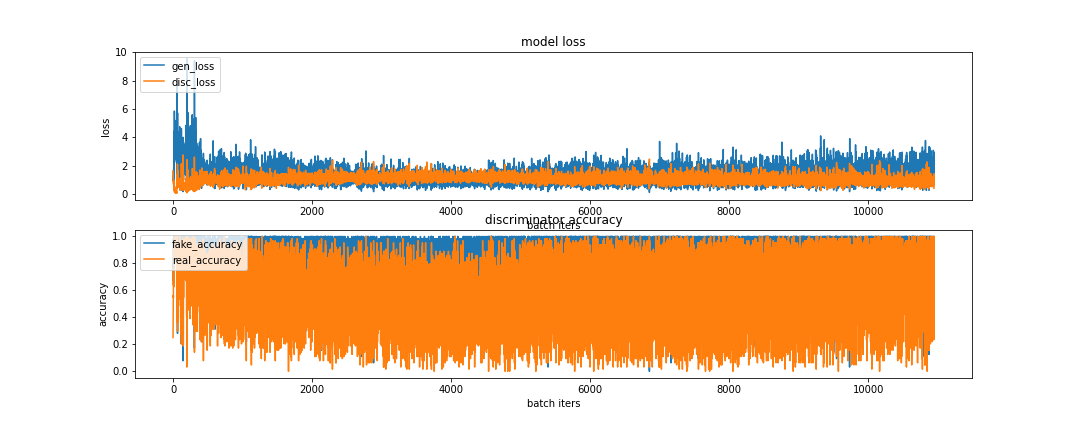

근데 그래프는 왜........ (좌절)

### Optimizer 별 Graph

Adadelta

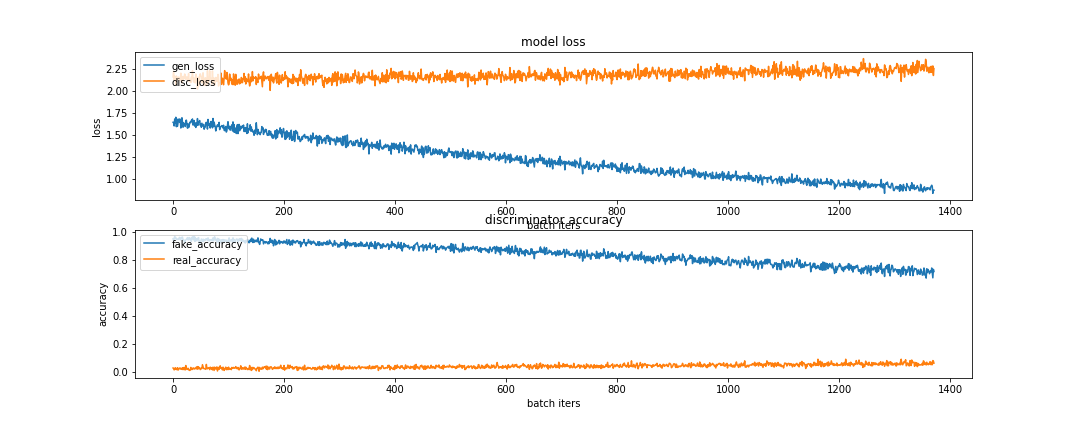

Nadam

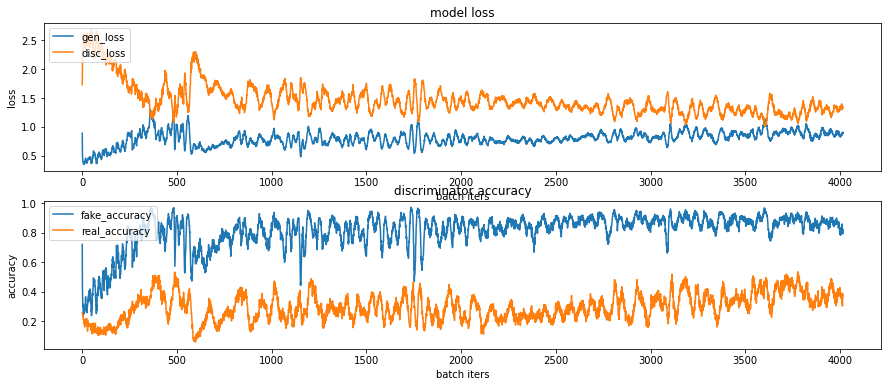

Adagrad

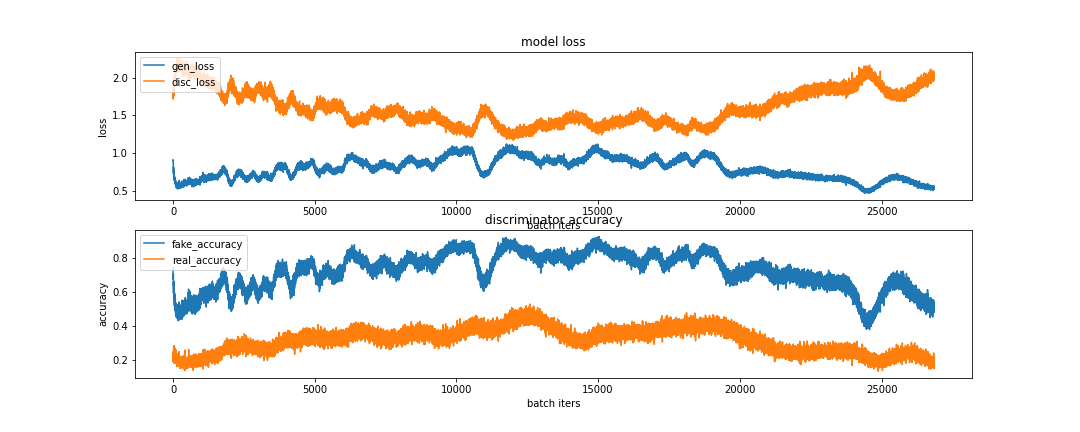

이거 0.5로 수렴하는걸로 봐줄수있는부분?? 껄껄

SGD

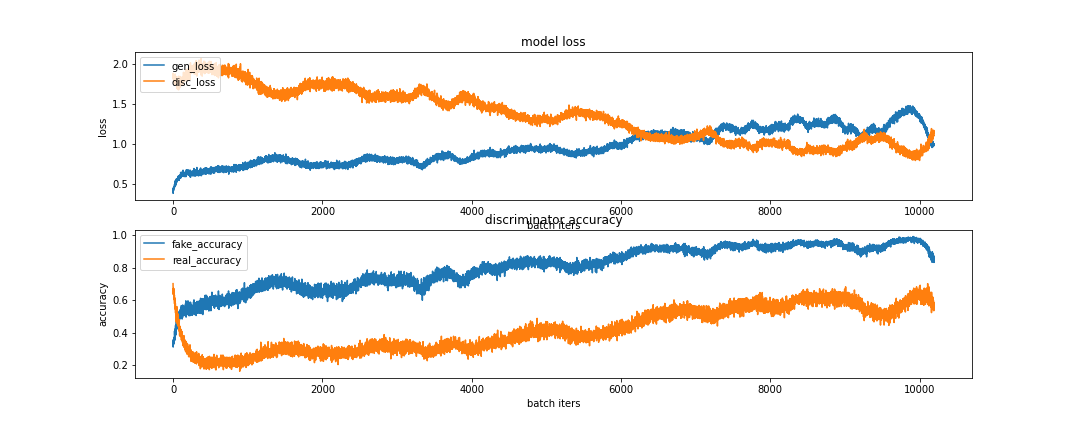

SGD 자체가 느리다보니 저런 그래프가 나왔다. 제일 괜찮아보임. 근데 생성된 이미지는 .. ktx타고 가면서 봐도 가짜이미지.

### Idea 1 : Early Stopping을 사용할 수 있을까? 
epoch가 진행 될 때마다 수렴하는 것 같다가 올라가는 모습을 목격했다. DCGAN에서도 early stopping을 사용하면 적절한 그래프를 보이는 optima를 얻을 수 있지 않을까?  
근데 생각해보면 earlystopping을 한다고 쳤을 때 그 때의 이미지 결과는 아직 우리가 원하는 이미지가 아니지 않을까? 흠.. 게다가 결정적인 이유가 있었다. 

#### Advantage of GAN
* Maximum Likelihood Estimation을 포함하지 않기 때문에 clear한 이미지가 생성된다.
& Generator는 training image를 본 적이 없기 때문에 overfitting 되지 않는다.
GAN은 distribution의 modes를 잘 포착한다.  

#### Issue of GAN
* **Nash equilibrium(Optimal Solution)을 달성하기가 어렵다**. -> 수렴하지 않을 수 있다.
(내시 균형(Nash equilibrium)은 게임 이론에서 경쟁자 대응에 따라 최선의 선택을 하면 서로가 자신의 선택을 바꾸지 않는 균형상태를 말한다. 상대방이 현재 전략을 유지한다는 전제 하에 나 자신도 현재 전략을 바꿀 유인이 없는 상태를 말하는 것으로 죄수의 딜레마(Prisoner's Dilemma)와 밀접한 관계가 있다.)
* **Generator의 목적은 실제와 같은 이미지를 생성하는 것이지만 loss로 주어지는 목적은 Discriminator를 속이는 것이다. 실제 목적과 loss의 목적의 불일치로 문제가 발생한다.**

### Idea 2 : Discriminator에 이미지를 넣기 전에 노이즈 주면?

Add noise to the real and generated images before feeding them into the discriminator. 라는 의견이 있어서 

```
import cv2
import numpy as np
from skimage.util import random_noise

# Add salt-and-pepper noise to the image
noise = random_noise(train_x[1], mode='s&p', amount=0.011)

# The above function returns a floating-point image in the range [0, 1]
# so need to change it to 'uint8' with range [0,255]
noise = np.array(255 * noise, dtype=np.uint8)

plt.imshow(noise)
plt.show()
```

위 코드 참고해서

```
for images in train_x:
    noise = random_noise(images, mode='s&p', amount=0.011)
    noise = np.array(255 * noise, dtype=np.uint8)
    noise = (noise - 127.5) / 127.5
```



요렇게 train_x 데이터를 변환해서 노이즈 넣고

이걸 train dataset 만들 때 넣어줌.. noise 준 이미지를 주면 discriminator가 너무 선명한 이미지와 generate 된 이미지를 헷갈려하지 않을까?


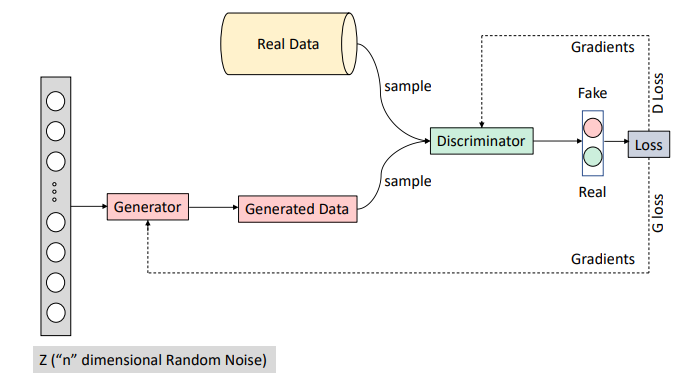

사진출처 : Kora Venu, S.; Ravula, S.Evaluation of Deep Convolutional Generative Adversarial Networks for Data Augmentation of Chest X-ray Images. Future Internet 2021, 13, 8.

근데 문득 저 구조 사진을 보게 되고 real image 자체를 노이즈 처리한다면 안 할때와 결과가 같지않을까? discriminator가 generated image를 비교할 때만 사용한다면 좋을텐데.. 하고 몇번 해보고 포기.. 하핫?!

---

## 🎯 평가 루브릭

| **평가문항** | **상세기준** | **학습결과** |
|:---:|---|:---:|
| 1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다. | 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다. | O |
| 2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다. | gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다. | X |
| 3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다. | 모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다. | O |

## ✍ 회고

* early stopping에 맛을 본 이후로 여기도 써보고 싶어서 찾아봤으나, GAN은 보통 underfitting 된다고 한다. 구조상 Generator는 real image를 본 적 없이 Discriminator의 반응(똑같다 이녀석아 / 안똑같다 이녀석아) 을 이용해서만 학습하니까. overfitting 될 수가 없는것.

* 인내심..? 이 필요한 ex였음..
    진짜 잘해보려고 했는데 쉽지않다..

* 그래프 밀당이 장난아니다. 그래서 더 포기 못하겠달까..?

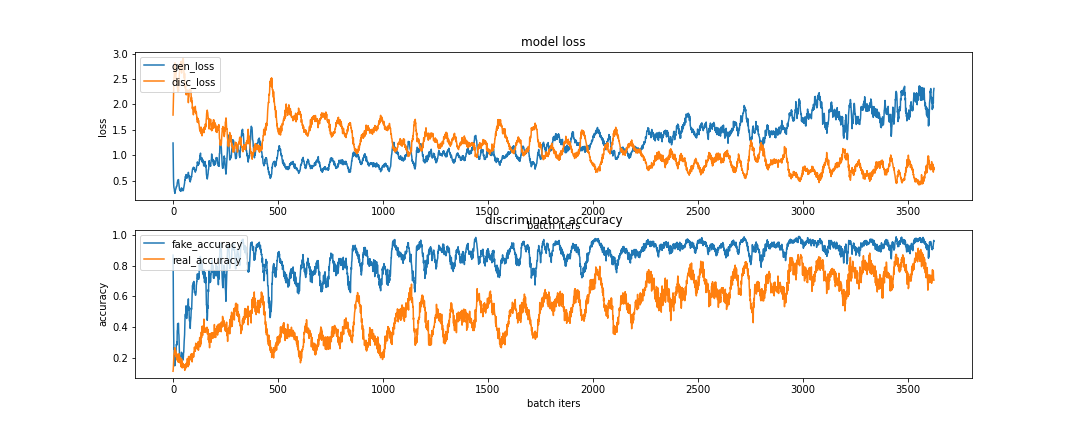

* adam optimizer의 beta_1 값을 0.9-> 0으로 하고 decay비율을 0->1e-4 로 바꿨더니 유의미하게 fake accuracy가 살짝 내려오는 결과를 얻었다. 가보자고
* 근데이제 real accuracy가 0으로 수렴함.. 

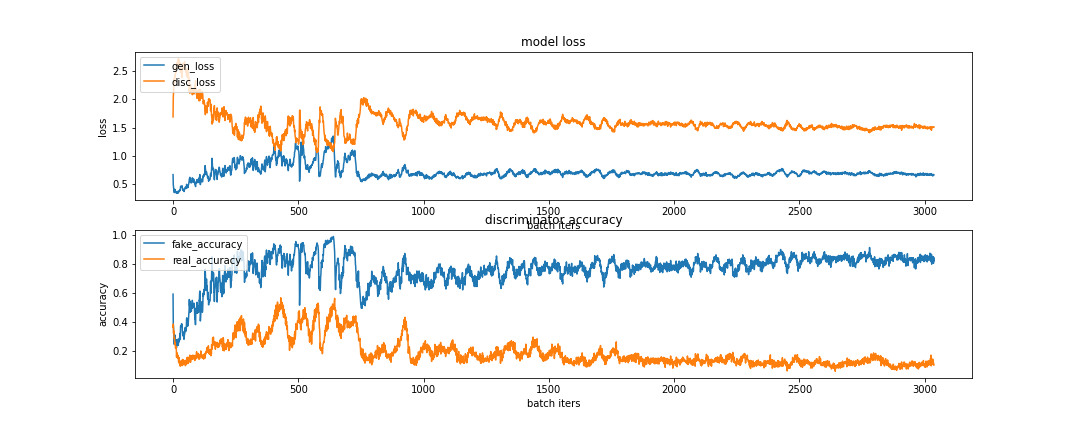

* 전체적인 훈련을 수행하면서, Nash equilibrium(Optimal Solution)이라는 개념이 직관적으로 이해가 갔다. discriminator가 적당히 판별하고 generator가 적당히 잘 만들어서 잘 속이는 그 equilibrium이 중요하다는 것...! 넘 어렵다

* 결국 0.5로 수렴하는 모델은 만들지 못했지만 .. optimizer를 바꿔봤을 때, 학습률을 바꿔 봤을 때, adam의 경우 beta_1, beta_2, decay 값을 바꿔봤을 때 유의미한 변화가 있음을 알 수 있었고 인자를 다양하게 사용해볼 수 있는 계기가 되어 좋았습니다.

* 실습 내내 들었던 생각.. 그래프는 Discriminator가 가짜로 판별했을지언정.. 이미지는 진짜 이미지 못지않게 잘 나왔는데. 그게 더 중요한거 아닌가?? (아님)

---

## GAN 동작원리 파헤치기



* 왜 GAN은 underfitting 될까? 찾아보다가 GAN 의 동작원리에 대해서 공부해봤다!



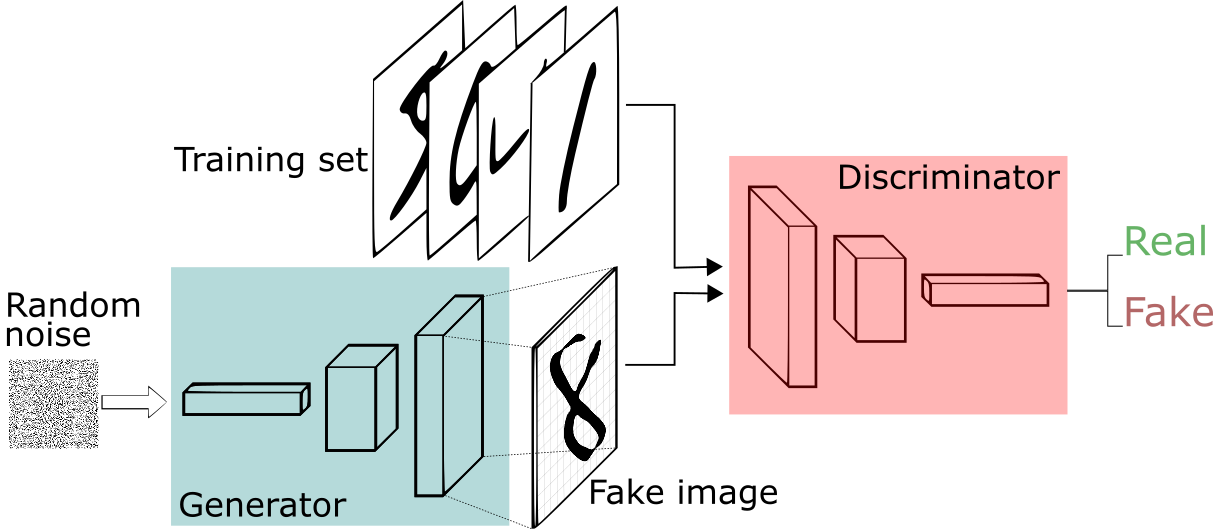

GAN은 Generator와 Discriminator를 가집니다.  
1. 랜덤노이즈를 생성합니다. (가우시안 분포, uniform dist.)
2. 해당 노이즈에서 벡터 z를 랜덤하게 추출합니다.  
3. 이 벡터 z를 입력으로 받아 generator는 가짜이미지를 매핑합니다.
4. generator의 layer를 거쳐가면 fake image는 생성되고 real image와 discriminator에서 비교됩니다. discriminator는 fake image가 실제 데이터에서 왔을 확률을 계산합니다.
5. discriminator는 진짜 이미지일수록 1에 가까운 값, 가짜일수록 0에 가까운 값을 출력하므로 두가지의 합으로 손실함수가 표현됩니다.
6. generator의 손실함수를 마찬가지로 계산해서 이를 최소화 시키도록 generator를 학습시키는 방향으로 반복

discriminator와 generator는 서로 가짜인지 진짜인지 판단하고 속이는.. 밑의 수식처럼 two-player minmax game을 하는 것과 같아집니다.  $\underset{G}min \underset{D}max\mathbb{E}_{x∼pdata} [log D(x)] + \mathbb{E}_{z∼p(z)}[log(1 − D(G(z))] $   

$\mathbb{E}_{x∼pdata} [log D(x)]$는 실제 데이터 x를 D가 보고 실제 데이터라고 판단할 확률 (D입장에서는 최대화/G입장에서는 최소화)  
$\mathbb{E}_{z∼p(z)}[log(1 − D(G(z))]$ 는 G가 만들어낸 데이터를 D가 가짜라고 판단할 확률 (D입장에서는 최대화/G입장에서는 최소화)



G와 D의 매커니즘을 봤을 때   
1. m개의 가짜 데이터를 pz에서 뽑아낸다.
2. m개의 진짜 데이터를 pdata에서 뽑아낸다.
3. D를 학습시킨다.
4. 위 과정을 k번 반복한다.
5. m개의 가짜 데이터를 pz에서 뽑아낸다.
6. G를 학습시킨다.
7. 1로 돌아간다.  
라고 합니다. 그래서 G는 진짜 이미지를 전혀 보지 못하고 **D의 반응만을 보고** 학습을 하게 되는 것입니다. ( 위 그림 참조 )  

GAN이 overfitting 될 수 없는 이유에서 말 했듯이 G는 real image를 본 적이 없기 때문에 overfitting이 될 수 없는겁니당..!


---

### 📚 참고문헌
* [GAN의 장단점](https://velog.io/@optjyy/GANGenerative-Adversarial-Network)
* [GAN의 underfitting 관련 논문](https://arxiv.org/pdf/1611.04273.pdf)
* [Ways to improve GAN performance](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)
* [DCGAN 모델 구조 참고 논문](https://danqi7.github.io/assets/pdf/429_GANs.pdf)
* [image augmentation_noise 생성법](https://stackoverflow.com/questions/59872616/how-to-add-noise-using-skimage)
* [GAN과 확률분포](https://comlini8-8.tistory.com/10)
* [수식으로 설명한 GAN](https://kangbk0120.github.io/articles/2017-07/first-gan) (이해가 쏙쏙)